# NanoSafety data summary

- using aggregated search

In [ ]:
import yaml
from solrscope import aa
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import requests
from importlib import reload 
from solrscope import client_solr
from solrscope import client_ambit
from solrscope import annotation
import pandas as pd
import numpy as np
import json
import pandas as pd
#import qgrid
import warnings
warnings.simplefilter("ignore")

In [ ]:
print('Select enanoMapper aggregated search service:')
style = {'description_width': 'initial'}
config,config_servers, config_security, auth_object, msg = aa.parseOpenAPI3()    
service_widget = widgets.Dropdown(
    options=config_servers['url'],
    description='Service:',
    disabled=False,
    style=style
)
if config_security is None:
    service = interactive(aa.search_service_open,url=service_widget)
else:
    print(msg)
    apikey_widget=widgets.Text(
            placeholder='',
            description=config_security,
            disabled=False,
            style=style
    )    
    service = interactive(aa.search_service_protected,url=service_widget,apikey=apikey_widget)    

display(service)

In [ ]:
service_uri=service_widget.value
if auth_object!=None:
    auth_object.setKey(apikey_widget.value)
print("Sending queries to {}".format(service_uri))
facets = client_solr.Facets()

In [4]:
    query_widget=widgets.Text(
        placeholder='',
        value="*:*",
        description="Query",
        disabled=False,
        style=style
    )
    display(query_widget)

Text(value='*:*', description='Query', placeholder='', style=DescriptionStyle(description_width='initial'))

In [31]:
method_field="E.method_s"
method_synonym="E.method_synonym_ss"
# method_field="guidance_s"

def summary(query="*:*",fq="type_s:study",statistics="Number of data points",fields=["topcategory_s","endpointcategory_s",method_field,"substanceType_s","publicname_s","reference_owner_s"]):
    colnames=["Z"]
    colnames.extend(fields)
    colnames.append(statistics)
    _stats=[]
    reload(client_solr)
    def process(prefix,val,count,key,_tuple):
        if len(_tuple)==len(fields):
            _tuple = (*_tuple,val,count)
            _stats.append(_tuple)
    q=facets.getQuery(query=query,facets=fields,fq=fq)
    #print(query)
    r = client_solr.post(service_uri,query=q,auth=auth_object)
    response_json=r.json()
    if r.status_code==200:
        #print(response_json)
        facets.parse(response_json['facets'],prefix=">",process=process)
        df = pd.DataFrame(_stats,columns=colnames).drop("Z", axis=1)
        if "substanceType_s" in df.columns:
            a = annotation.DictionarySubstancetypes()
            df[ 'substanceType_name']=df[ 'substanceType_s'].apply(a.annotate)
        if "substanceType_hs" in df.columns:
            a = annotation.DictionarySubstancetypes()
            df[ 'substanceType_name']=df[ 'substanceType_hs'].apply(a.annotate)            
        if "endpointcategory_s" in df.columns:    
            a = annotation.DictionaryEndpointCategory()
            df[ 'endpointcategory_term']=df[ 'endpointcategory_s'].apply(a.annotate)
            a = annotation.DictionaryEndpointCategoryNames()
            df[ 'endpointcategory_name']=df[ 'endpointcategory_s'].apply(a.annotate)
        
        if "method_term" in df.columns:
            a = annotation.DictionaryAssays()
            df[ 'method_term']=df[method_field].apply(a.annotate)
        return (df)
    else:
        print(r.status_code)
        return (None)
    
df = summary(query="*:*",fields=["topcategory_s","endpointcategory_s",method_synonym,method_field,"substanceType_s","publicname_s","reference_owner_s"])    
df.head()

,topcategory_s,endpointcategory_s,E.method_synonym_ss,E.method_s,substanceType_s,publicname_s,reference_owner_s,Number of data points,substanceType_name,endpointcategory_term,endpointcategory_name
0,TOX,TO_GENETIC_IN_VITRO_SECTION,ENM_8000273,MICRONUCLEUS ASSAY,CHEBI_59999,CONTROL,IPL,330,chemical substance,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
1,TOX,TO_GENETIC_IN_VITRO_SECTION,ENM_8000273,MICRONUCLEUS ASSAY,CHEBI_59999,CONTROL,ANSES,279,chemical substance,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
2,TOX,TO_GENETIC_IN_VITRO_SECTION,ENM_8000273,MICRONUCLEUS ASSAY,CHEBI_59999,CONTROL,INRS (FRANCE),236,chemical substance,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
3,TOX,TO_GENETIC_IN_VITRO_SECTION,ENM_8000273,MICRONUCLEUS ASSAY,CHEBI_59999,CONTROL,INSA,207,chemical substance,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
4,TOX,TO_GENETIC_IN_VITRO_SECTION,ENM_8000273,MICRONUCLEUS ASSAY,CHEBI_59999,CONTROL,FIOH,64,chemical substance,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro


In [6]:
table = pd.pivot_table(df, values='Number of data points', index=['topcategory_s','endpointcategory_name',method_synonym,method_field], columns=[ 'substanceType_s',"publicname_s"], aggfunc=np.sum).fillna("");
display(table)

table.reset_index().to_excel("method_material.xlsx")

substanceType_s                                                                                                                         CHEBI:133349  \
publicname_s                                                                                                                       NFC ENSO FINE NFC   
topcategory_s endpointcategory_name                         E.method_synonym_ss E.method_s                                                             
ECOTOX        Sediment toxicity                             _                   _                                                                      
              Short-term toxicity to aquatic inverterbrates OECD_TG201          OECD TG 201                                                            
                                                            OECD_TG202          OECD TG 202                                                            
                                                            _                   ACUTE TOXICITY                                                         
                                                                                DAPHNIA MAGNA                                                          
                                                                                SOP-Toxicity Test with Daphnia magna (without NOM)                     
                                                                                _                                                                      
              Short-term toxicity to fish                   ENM_8000224         ALAMAR BLUE                                                            
                                                            ENM_8000277         NRU                                                                    
                                                            _                   CFDA-AM                                                                
                                                                                _                                                                      
              Toxicity to aquatic algae and cyanobacteria   _                   PSEUDOKIRCHNERIELLA SUBCAPITATA                                        
                                                                                _                                                                      
              Toxicity to soil macroorganisms               _                   ISO 10872:2010 Water QualityDetermination of th...                     
                                                                                JRCNM01001a                                                            
              Toxicity to soil microorganisms               _                   _                                                                      
              Toxicity to terrestrial plants                _                   _                                                                      
P-CHEM        Aerosol characterisation                      _                   _                                                                      
              Agglomeration/aggregation                     NPO_1429            SEM                                                                    
                                                            OBI_0002108         SAXS                                                                   
              Analytical Methods                            CHMO_0000538        ICP-MS                                                                 
                                                            ENM_8000243         ICP-OES                                                                
                                                            _                   Chemical composition of particles                                      
                                                

In [33]:
table = pd.pivot_table(df, values='reference_owner_s', index=['topcategory_s','endpointcategory_name',method_field], columns=[ 'substanceType_name','publicname_s'], 
                             aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")

display(table.head())



substanceType_name                                                          (14)-beta-D-glucan  \
publicname_s                                                               BLEACHED BIRCH PULP   
topcategory_s endpointcategory_name                         E.method_s                           
ECOTOX        Sediment toxicity                             _                                    
              Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                       
                                                            DAPHNIA MAGNA                        
                                                            OECD TG 201                          
                                                            OECD TG 202                          

substanceType_name                                                                         \
publicname_s                                                               UPM BIRCH PULP   
topcategory_s endpointcategory_name                         E.method_s                      
ECOTOX        Sediment toxicity                             _                               
              Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                  
                                                            DAPHNIA MAGNA                   
                                                            OECD TG 201                     
                                                            OECD TG 202                     

substanceType_name                                                                                  \
publicname_s                                                               UPM Bleached Birch Pulp   
topcategory_s endpointcategory_name                         E.method_s                               
ECOTOX        Sediment toxicity                             _                                        
              Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                           
                                                            DAPHNIA MAGNA                            
                                                            OECD TG 201                              
                                                            OECD TG 202                              

substanceType_name                                                          Lipopolysacharide  \
publicname_s                                                               LIPOPOLYSACCHARIDE   
topcategory_s endpointcategory_name                         E.method_s                          
ECOTOX        Sediment toxicity                             _                                   
              Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                      
                                                            DAPHNIA MAGNA                       
                                                            OECD TG 201                         
                                                            OECD TG 202                         

substanceType_name                                                                          NPO_1373\t  \
publicname_s                                                               25 NM (+) GREEN FLUORESCENT   
topcategory_s endpointcategory_name                         E.method_s                                   
ECOTOX        Sediment toxicity                             _                                            
              Short-term toxicity to aquatic inverterbrates ACUTE TOXICITY                               
                                                            DAPHNIA MAGNA                                
                                                            OECD TG 201                                  
                                                            OECD TG 202                                  

substanceType_name         

In [34]:
table.reset_index().to_excel("method_material_provider.xlsx")

# Misc statistics 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_palette(sns.color_palette("hls", 8))
sns.set_palette(sns.color_palette("Set1"))


In [12]:
df = summary(query="*:*",fq="type_s:study",statistics="Number of data points",
                 fields=["topcategory_s","endpointcategory_s",method_field,"owner_name_s","reference_owner_s","substanceType_s"])    
df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type"},inplace=True)    
df.head()

,Study type,endpointcategory_s,E.method_s,Project,reference_owner_s,substanceType_s,Number of data points,NM type,endpointcategory_term,endpointcategory_name
0,TOX,TO_GENETIC_IN_VITRO_SECTION,MICRONUCLEUS ASSAY,NanoGenotox,ANSES,NPO_354,654,multi-walled carbon nanotube,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
1,TOX,TO_GENETIC_IN_VITRO_SECTION,MICRONUCLEUS ASSAY,NanoGenotox,ANSES,CHEBI_59999,599,chemical substance,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
2,TOX,TO_GENETIC_IN_VITRO_SECTION,MICRONUCLEUS ASSAY,NanoGenotox,ANSES,NPO_1373,480,silicon dioxide nanoparticle,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
3,TOX,TO_GENETIC_IN_VITRO_SECTION,MICRONUCLEUS ASSAY,NanoGenotox,ANSES,NPO_1486,462,titanium dioxide,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
4,TOX,TO_GENETIC_IN_VITRO_SECTION,MICRONUCLEUS ASSAY,NanoGenotox,ANSES,NPO_1542,275,zinc oxide nanoparticle,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro


Project,ENPRA,MARINA,NANoREG,NanoGenotox,NanoTest
Study type,,,,,
ECOTOX,0.0,70.0,345.0,0.0,0.0
P-CHEM,0.0,275.0,12814.0,411.0,31.0
TOX,3310.0,15687.0,26235.0,26338.0,13901.0


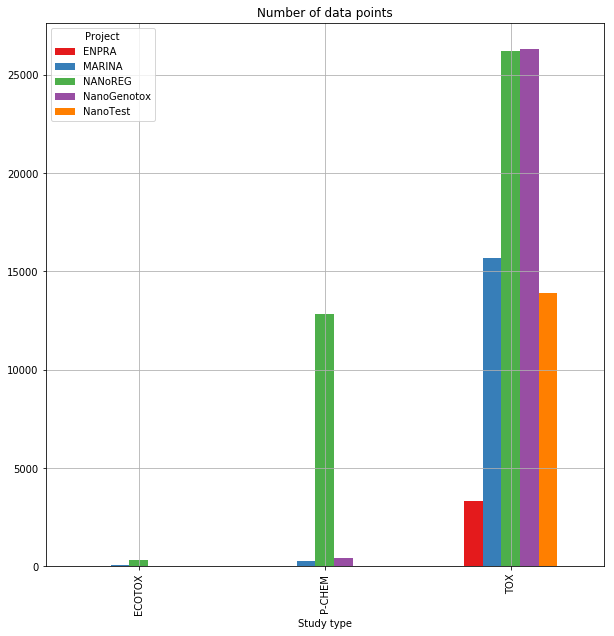

In [19]:
#use this to find where method field is missing
#table = pd.pivot_table(df, values=method_field, index=['topcategory_s','endpointcategory_name'], columns=[ 'owner_name_s'], aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")
table = pd.pivot_table(df, values="Number of data points", index=['Study type'], columns=[ 'Project'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(10,10) ,sharey =True,title="Number of data points", grid=True)
fig = p.get_figure()
fig.savefig("studytype_datapoints.png")

## Methods summary

In [17]:
#Methods summary
#table = pd.pivot_table(df, values=method_field, index=['Study type','endpointcategory_name'], columns=[ 'Project'], aggfunc=lambda x: ' '.join(str(v) for v in x)).fillna("")
table = pd.pivot_table(df, values=method_field, index=['Study type','endpointcategory_name'], columns=[ 'Project'], aggfunc=lambda x: ';'.join(set(str(v) for v in x))).fillna("")
table.head(20)

Project                                                  ENPRA  \
Study type endpointcategory_name                                 
ECOTOX     Sediment toxicity                                     
           Short-term toxicity to aquatic inverterbrates         
           Short-term toxicity to fish                           
           Toxicity to aquatic algae and cyanobacteria           
           Toxicity to soil macroorganisms                       
           Toxicity to soil microorganisms                       
           Toxicity to terrestrial plants                        
P-CHEM     Aerosol characterisation                              
           Agglomeration/aggregation                             
           Analytical Methods                                    
           Appearance                                            
           Aspect ratio/shape                                    
           Batch Dispersionquality                               
           Crystalline phase                                     
           Crystallite and grain phase                           
           Density                                               
           Dustiness                                             
           Particlesize distribution(Granulometry)               
           Physchem(other)                                       
           Porosity                                              

Project                                                                                              MARINA  \
Study type endpointcategory_name                                                                              
ECOTOX     Sediment toxicity                                                                              _   
           Short-term toxicity to aquatic inverterbrates                                                  _   
           Short-term toxicity to fish                                            CFDA-AM;NRU;ALAMAR BLUE;_   
           Toxicity to aquatic algae and cyanobacteria                                                    _   
           Toxicity to soil macroorganisms                                                                    
           Toxicity to soil microorganisms                                                                _   
           Toxicity to terrestrial plants                                                                 _   
P-CHEM     Aerosol characterisation                                                                           
           Agglomeration/aggregation                                                                    SEM   
           Analytical Methods                             ICP-OES;ICP-MS;X-ray Photoelectron Spectroscop...   
           Appearance                                                                                         
           Aspect ratio/shape                                                                           SEM   
           Batch Dispersionquality                                                                            
           Crystalline phase                                                                            XRD   
           Crystallite and grain phase                                                                  XRD   
           Density                                                                                        _   
           Dustiness                                                                                      _   
           Particlesize distribution(Granulometry)        _;SEM;Differential Centrifugal Sedimentation (...   
           Physchem(other)                                                                                    
           Porosity                                                                                       _   

Project                                                                                             NANo

## Number of data points per material and project

Project,ENPRA,MARINA,NANoREG,NanoGenotox,NanoTest
NM type,,,,,
(14)-beta-D-glucan,0.0,0.0,365.0,0.0,0.0
Lipopolysacharide,0.0,12.0,0.0,0.0,0.0
NPO_1373\t,0.0,0.0,5.0,0.0,0.0
PLGA nanoparticle,0.0,0.0,0.0,0.0,2000.0
_,0.0,0.0,60.0,350.0,0.0
barium sulfate,0.0,3.0,1548.0,0.0,0.0
calcium carbonate,0.0,0.0,42.0,0.0,0.0
carbon nanotube,0.0,0.0,276.0,0.0,0.0
cerium oxide nanoparticle,0.0,0.0,2508.0,0.0,0.0


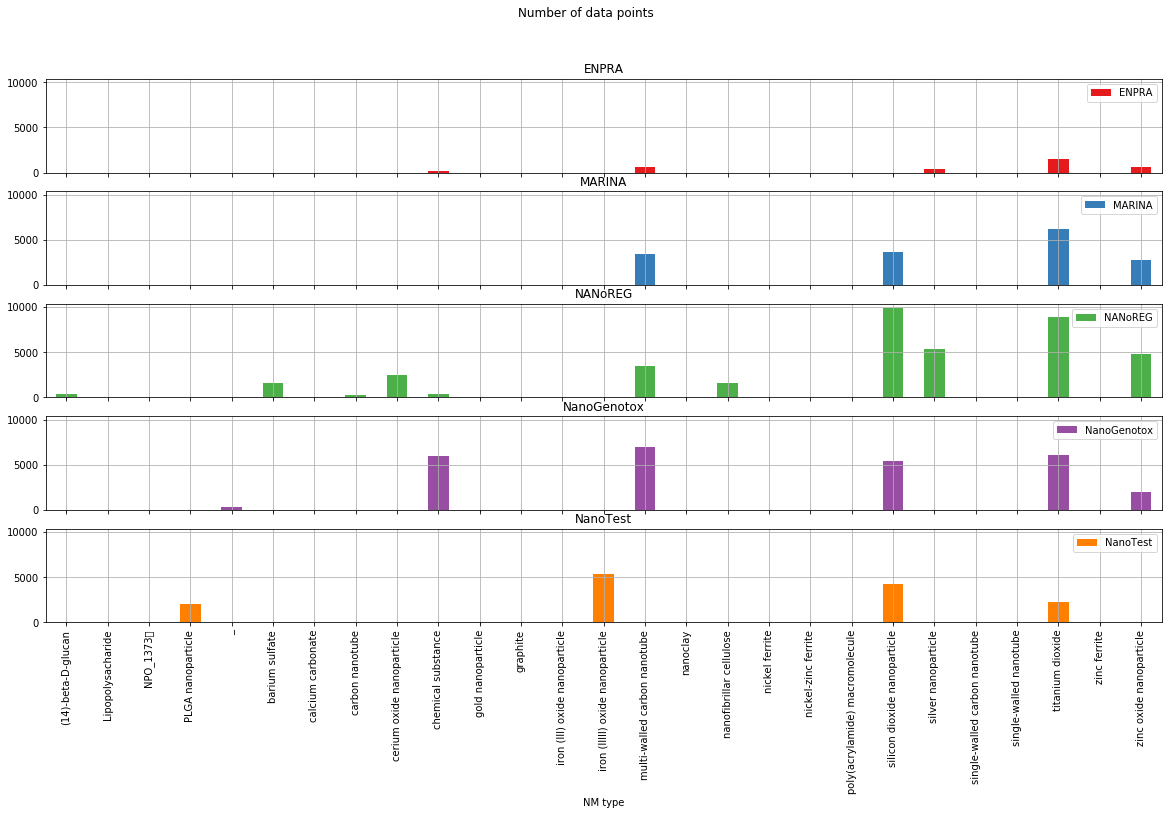

In [20]:
table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=[ 'Project'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(20,10) ,title="Number of data points", grid=True, stacked =False, sharey=True, subplots=True)
#fig = p.get_figure()
#fig.savefig("nmtype_datapoints.png")

## Number of data points per material and study type

In [ ]:
table = pd.pivot_table(df, values="Number of data points", columns=['NM type'], index=[ 'Study type'], aggfunc=np.sum).fillna(0);
display(table)
p = table.plot(kind="bar",  figsize=(20,10) ,title="Number of data points", grid=True, stacked =False, sharey=True, subplots=False)
#fig = p.get_figure()
#fig.savefig("nmtype_datapoints.png")

# Materials

In [22]:
import matplotlib.pyplot as plt
binary = ["#ff0000","#00ff00"]
sns.set_palette(binary)
#red/green palette
#sns.palplot(sns.color_palette())
  
def plot_heatmap(table,q):    
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(10,10)
    #fig.set_size_inches(11.7/4, 8.27/4)
    sns_plot = sns.heatmap(table, cmap=binary)
    sns_plot.set_title(q)
    sns_plot.get_figure().savefig(q+".png")
    return (sns_plot)


In [23]:
df = summary(query="*:*",fq="type_s:substance",statistics="Number of NM", fields=["owner_name_hs","substanceType_hs","publicname_hs"])    
df.rename(columns={"owner_name_hs" : "Project","topcategory_s":"Study type","substanceType_name": "NM type"},inplace=True)

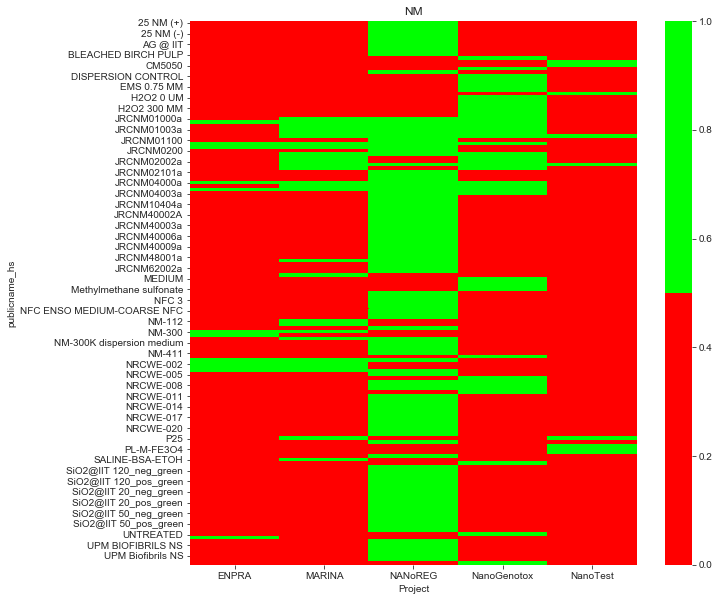

In [24]:
table = pd.pivot_table(df, values="Number of NM", index=['publicname_hs'], columns=[ 'Project'], aggfunc='any').fillna(False)
plot_heatmap(table,"NM")

# Endpoints

In [25]:
def queryEndpoints(_query="topcategory_s:TOX"):
    print(_query)
    df = summary(query=_query,fq="type_s:study",statistics="Number of data points", fields=["topcategory_s","endpointcategory_s","effectendpoint_s","substanceType_s","publicname_s"])        
    df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type","endpointcategory_name":"endpoint"},inplace=True)
    table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=['endpoint' ], aggfunc='any').fillna(False)
    return (df,table)



topcategory_s:TOX


,Study type,endpointcategory_s,effectendpoint_s,substanceType_s,publicname_s,Number of data points,NM type,endpointcategory_term,endpoint
0,TOX,TO_GENETIC_IN_VITRO_SECTION,NUMBER OF SCORED CELLS,NPO_354,JRCNM04003a,263,multi-walled carbon nanotube,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
1,TOX,TO_GENETIC_IN_VITRO_SECTION,NUMBER OF SCORED CELLS,NPO_354,JRCNM04002a,164,multi-walled carbon nanotube,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
2,TOX,TO_GENETIC_IN_VITRO_SECTION,NUMBER OF SCORED CELLS,NPO_354,JRCNM04000a,162,multi-walled carbon nanotube,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
3,TOX,TO_GENETIC_IN_VITRO_SECTION,NUMBER OF SCORED CELLS,NPO_354,NRCWE-006,157,multi-walled carbon nanotube,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro
4,TOX,TO_GENETIC_IN_VITRO_SECTION,NUMBER OF SCORED CELLS,NPO_354,NRCWE-007,157,multi-walled carbon nanotube,http://www.bioassayontology.org/bao#BAO_0002167,Genetic toxicity invitro


endpoint,Barrier integrity,CellViability,Genetic toxicity invitro,Genetic toxicity invivo,Immunotoxicity,Oxidative Stress,Repeated dose toxicity-inhalation,Repeated dose toxicity-oral,Toxicity(other)
NM type,,,,,,,,,
(14)-beta-D-glucan,False,True,True,True,True,False,True,False,False
Lipopolysacharide,False,False,False,False,False,False,False,False,True
PLGA nanoparticle,False,True,False,False,True,True,False,False,False
_,False,False,True,False,False,False,False,True,False
barium sulfate,False,True,True,False,True,True,False,False,False
carbon nanotube,False,False,True,False,False,False,False,True,False
cerium oxide nanoparticle,True,True,True,False,True,True,True,False,False
chemical substance,False,True,True,False,True,True,False,False,True
iron (IIIII) oxide nanoparticle,False,True,True,False,True,True,False,False,True


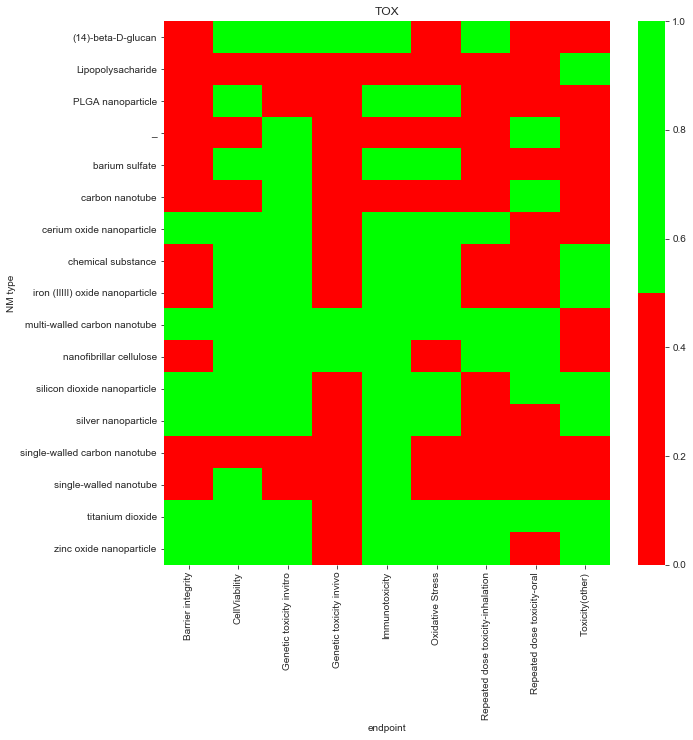

In [26]:
q="TOX"
df,table=queryEndpoints(_query="topcategory_s:"+q)
display(df.head())
display(table)
plot_heatmap(table,q)

topcategory_s:P-CHEM


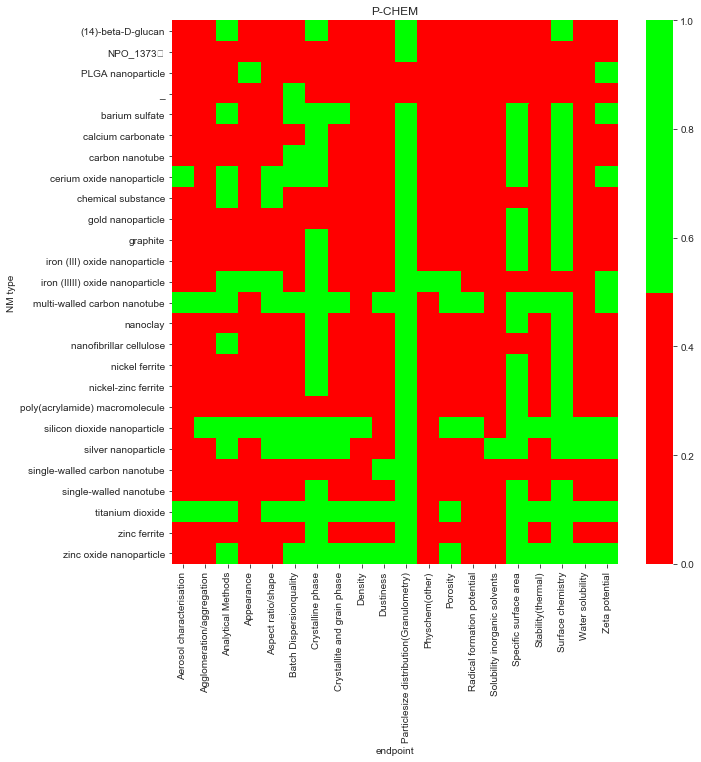

In [27]:
q="P-CHEM"
df,table=queryEndpoints(_query="topcategory_s:"+q)
plot_heatmap(table,q)

topcategory_s:ECOTOX


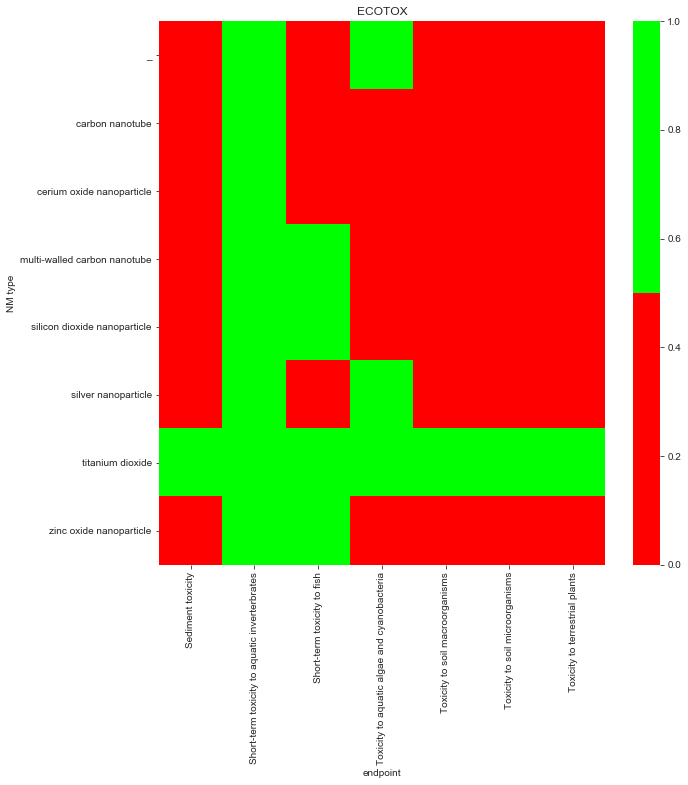

In [29]:
q="ECOTOX"
df,table=queryEndpoints(_query="topcategory_s:"+q)
plot_heatmap(table,q)